In [243]:
# Load all the tools
import numpy as np
# from wisdem.aeroelasticse.CaseLibrary import ROSCO_Test
import os

from weis.aeroelasticse.FAST_reader import InputReader_Common, InputReader_OpenFAST, InputReader_FAST7
from weis.aeroelasticse.FAST_writer import InputWriter_Common, InputWriter_OpenFAST, InputWriter_FAST7
from weis.aeroelasticse.runFAST_pywrapper import runFAST_pywrapper_batch
from weis.aeroelasticse.CaseGen_General import CaseGen_General
from weis.aeroelasticse.CaseGen_IEC import CaseGen_IEC
from pCrunch import pdTools
from pCrunch import Processing, Analysis
from weis.aeroelasticse.Util import FileTools
# Instantiate fast_IO
from ROSCO_toolbox import utilities as ROSCO_utilities
fast_io = ROSCO_utilities.FAST_IO()
fast_pl = ROSCO_utilities.FAST_Plots()
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib widget



# Test Results Directory

In [317]:
sim_case = 'simp+fl_gain'


# Pitch Control Sweep
test_dir = ['/Users/dzalkind/Tools/WEIS-3/outputs/iea15mw/PC_sweep_play']

# Floating Feedback Sweep
test_dir = ['/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_fixed_ps100_const_pwr/simp_fl']

# Phase Sweep


if sim_case == 'ntm+pc_mode':
    test_dir = [
               '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_CT-spar_ps100/ntm+pc_mode',
               ]
elif sim_case == 'simp+pc_mode':
    test_dir = [
               '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_CT-spar_ps100/simp+pc_mode',
               ]
    
elif sim_case == 'simp+fl_phase':
    test_dir = [
#                '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_CT-spar_ps100/simp+fl_phase',
        '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_CT-spar_lowBW/simp+fl_phase'
               ]
    
elif sim_case == 'simp+fl_gain':
    test_dir = [
#                '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_CT-spar_ps100/simp+fl_phase',
        '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_CT-spar_lowBW/simp+fl_gain'
               ]
    
elif sim_case == 'simp+yaw':
    test_dir = [
#                '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_CT-spar_ps100/simp+fl_phase',
        '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_CT-spar_lowBW/simp+yaw'
               ]
    

# name_base  = 'dataset1'

In [318]:
# Load case matrix into dataframe
case_matrix = [None] * len(test_dir)
cm   = [None] * len(test_dir)
fastFile  = [None] * len(test_dir)
fastRead  = [None] * len(test_dir)

for i, dir in enumerate(test_dir):
    case_matrix[i] = FileTools.load_yaml(os.path.join(test_dir[i],'case_matrix.yaml'), package=1)
    cm[i] = pd.DataFrame(case_matrix[i])

    # Get ALL FAST info
    fastRead[i] = InputReader_OpenFAST(FAST_ver='OpenFAST', dev_branch=True)
    fastFile[i] = os.path.join(test_dir[i],cm[i]['Case_Name'][0] + '.fst')
    fastRead[i].FAST_InputFile = os.path.basename(fastFile[i])   # FAST input file (ext=.fst)
    fastRead[i].FAST_directory = os.path.dirname(fastFile[i])   # Path to fst directory files
    fastRead[i].execute()


Loading rotor performace data from text file: /Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_CT-spar_lowBW/simp+fl_gain/step_0_Cp_Ct_Cq.txt


$x^2$

In [319]:
# inds = [
#         ('meta','Fl_Phase'),
#     ('DISCON_in', 'F_FlCornerFreq'),
#     ('DISCON_in', 'F_FlHighPassFreq'),
#     ('DISCON_in', 'Fl_Kp'),
    
# ]


if 'pc_mode' in sim_case:
    inds = [
            ('meta','omega'),
            ('meta','zeta'),
        ('InflowWind','Filename')

    ]
elif 'fl_phase' in sim_case:
    inds = [
        ('meta', 'phase_30'),
        ('DISCON_in', 'F_FlCornerFreq'),
        ('DISCON_in', 'F_FlHighPassFreq'),
        ('DISCON_in', 'Fl_Kp'),
    ]

elif 'fl_gain' in sim_case:
    inds = [
        ('DISCON_in', 'F_FlCornerFreq'),
        ('DISCON_in', 'Fl_Kp'),
    ]
elif 'yaw' in sim_case:
    inds = [
        ('ElastoDyn', 'NacYaw')
    ]
else:
    print('WARNING: your sim_case is messed up')

cm[0][inds].head(30)



,"(DISCON_in, F_FlCornerFreq)","(DISCON_in, Fl_Kp)"
0,"[0.16, 1.0]",0.0
1,"[0.16, 1.0]",-3.6
2,"[0.16, 1.0]",-7.2
3,"[0.16, 1.0]",-10.8
4,"[0.16, 1.0]",-14.4
5,"[0.16, 1.0]",-18.0


In [320]:
# Set up pCrunch, run if not already
reCrunch = False

name_base = 'dataset1'
# Do stats yaml exist?
stat_yaml_there = [os.path.exists(os.path.join(test,'stats',name_base + '_stats.yaml')) for test in test_dir]

outfiles = [[os.path.join(test, cn + '.outb') for cn in cm[0].Case_Name] for test in test_dir]



fp = [None]*len(test_dir)
st = [None]*len(test_dir)
lr = [None]*len(test_dir)
stats = [None]*len(test_dir)
load_rankings = [None]*len(test_dir)
# Load and save statistics and load rankings
for i_test, test in enumerate(test_dir):
    if not stat_yaml_there[i_test] or reCrunch:

        # Set some processing parameters
        fp[i_test] = Processing.FAST_Processing()
        fp[i_test].results_dir              = os.path.join(test, 'stats')
        fp[i_test].OpenFAST_outfile_list    = outfiles[i_test]
        fp[i_test].t0                       = 200         
        fp[i_test].parallel_analysis        = True
        fp[i_test].parallel_cores           = 8
#         fp[i_test].DEL_info = [('TwrBsMyt', 4)]#, ('RootMyb2', 10), ('RootMyb3', 10)]


        fp[i_test].verbose                  = True
        fp[i_test].save_LoadRanking         = True
        fp[i_test].save_SummaryStats        = True
        
        fp[i_test].ranking_vars.append(['GenPwr']), fp[i_test].ranking_stats.append('max')
        fp[i_test].ranking_vars.append(['GenSpeed']), fp[i_test].ranking_stats.append('std')
        fp[i_test].ranking_vars.append(['TwrBsMyt']), fp[i_test].ranking_stats.append('max')
        fp[i_test].ranking_vars.append(['TwrBsMyt']), fp[i_test].ranking_stats.append('std')
        fp[i_test].ranking_vars.append(['TwrBsMxt']), fp[i_test].ranking_stats.append('max')
        fp[i_test].ranking_vars.append(['NcIMUTAxs']), fp[i_test].ranking_stats.append('std')
        fp[i_test].ranking_vars.append(['NcIMUTAys']), fp[i_test].ranking_stats.append('std')

        stats[i_test], load_rankings[i_test] = fp[i_test].batch_processing()
        
    # re-load to get rid of dataset
    stats[i_test] = FileTools.load_yaml(os.path.join(os.path.join(test, 'stats'),name_base+'_stats.yaml'), package=1)
    load_rankings[i_test] = FileTools.load_yaml(os.path.join(os.path.join(test, 'stats'),name_base+'_LoadRanking.yaml'), package=1)

    # Turn into dataframe
    st[i_test] = pdTools.dict2df(stats[i_test])
    lr[i_test] = pdTools.dict2df(load_rankings[i_test])
    


Calculating load rankings.
Saving dataset1_stats.yaml
Saving dataset1_LoadRanking.yaml


Look at raw data here

In [321]:
# Load Ranking

st[0]['TwrBsMyt']

# cm[0]['meta','phase_50']

,abs,integrated,max,mean,min,std
0,466251.280013,8.085060e+07,466251.280013,324416.519374,124928.629958,97397.767626
1,452063.895653,4.767846e+07,452063.895653,328709.612876,172943.919011,76543.233997
2,448309.450438,-5.872842e+07,448309.450438,334219.748253,193056.848381,58693.694958
3,442863.077844,-3.348864e+07,442863.077844,338511.682167,211769.466070,45200.162526
4,437802.018188,7.974932e+06,437802.018188,339902.844830,228019.085440,39616.767372
5,433103.019075,-7.276550e+06,433103.019075,342005.403709,241574.337599,35295.542878


# Parameter-Based Scatter Plots

In [322]:
# Add parameter to stat df

windspeeds = [st_i['Wind1VelX']['mean'].to_numpy() for st_i in st]

parameters = []
if True:
    for c, ws in zip(cm,windspeeds):
        c[('meta','MeanWS')] = ws.astype(int)

if 'pc_mode' in sim_case:
    parameters = [
        ('meta','omega'),
        ('meta','zeta'),
        ('meta','MeanWS')
    ]
elif 'fl_phase' in sim_case:
    parameters = [
        ('meta','phase_30'),
        ('meta','phase_50'),
        ('meta','MeanWS'),
        'Case_ID',
#         ('TwrBsMyt','std'),
        ('DISCON_in', 'F_FlCornerFreq'),
        ('DISCON_in', 'Fl_Kp')
        
    ]
    
elif 'fl_gain' in sim_case:
    parameters = [
        ('meta','MeanWS'),
        'Case_ID',
        ('DISCON_in', 'F_FlCornerFreq'),
        ('DISCON_in', 'Fl_Kp')
        
    ]
    
elif 'yaw' in sim_case:
    parameters = [
        ('meta','MeanWS'),
        'Case_ID',
        ('ElastoDyn', 'NacYaw')       
    ]

# parameters
# parameter = ('DISCON_in','Fl_Kp')

# Add cm fields to st
p2 = [None] * len(parameters)
for i_dir in range(0,len(st)):
    for i_param, param in enumerate(parameters):
        if isinstance(param,tuple):
            st[i_dir][param[0],param[1]] = cm[i_dir][param]
            p2[i_param] = param
        else:
            st[i_dir]['meta',param] = cm[i_dir][param]
            p2[i_param] = ('meta',param)
parameters = p2


# Add st fields to parameters
st_parameters = [
    ('TwrBsMyt','std'),
    ('PtfmPitch','std'),
    ('PtfmYaw','std')
    
]

for st_p in st_parameters:
    parameters.append(st_p)

st[0][parameters[3]]

0     0.0
1    -3.6
2    -7.2
3   -10.8
4   -14.4
5   -18.0
Name: (DISCON_in, Fl_Kp), dtype: float64

Select Cases

In [323]:
indSel  = [True] * len(st[0])

if 'pc_mode' in sim_case:
    indZeta = st[0]['meta','zeta'] == 1.5
    indWind = st[0]['meta','MeanWS'] == 12
    indSel  = indZeta & indWind

    
elif 'fl_phase' in sim_case:
    # indOmega1 = st[0]['meta','omega'] > 0.07
    # indPhase = st[0]['meta','phase_30'] > -9000
    indWind = st[0]['meta','MeanWS'] == 12
    indSel = indWind
    
elif 'fl_gain' in sim_case:
    # indOmega1 = st[0]['meta','omega'] > 0.07
    # indPhase = st[0]['meta','phase_30'] > -9000
    indWind = st[0]['meta','MeanWS'] == 10
    indSel = indWind

elif 'yaw' in sim_case:
    # indOmega1 = st[0]['meta','omega'] > 0.07
    # indPhase = st[0]['meta','phase_30'] > -9000
    indWind = st[0]['meta','MeanWS'] == 10
    indSel = indWind

st[0]['TwrBsMyt','std'].loc[indSel]
st[0][parameters].loc[indSel]
# parameters


# st[0][parameters].loc[indSel]
# parameters
# st[0]['InflowWind','Filename'][150]
# cm[0][('InflowWind','Filename')][150]
# i_dir
# cm[i_dir][param][150]
# st[i_dir][param[0],param[1]]

# ws.astype(int)

# st[0]['meta','MeanWS']

# Best 11 - 12: -21 (10000), 28
# Best 10 - 11: -33 (6300), 16
# Best 12 - 13: -18 (22000), 48
# Best 12 - 13: -12 (9000), 

meta              DISCON_in            TwrBsMyt PtfmPitch   PtfmYaw
  MeanWS Case_ID F_FlCornerFreq Fl_Kp           std       std       std
0     10       0    [0.16, 1.0]   0.0  97397.767626  1.417812  0.125676
1     10       1    [0.16, 1.0]  -3.6  76543.233997  1.109647  0.112575
2     10       2    [0.16, 1.0]  -7.2  58693.694958  0.847034  0.107332
3     10       3    [0.16, 1.0] -10.8  45200.162526  0.647100  0.105726
4     10       4    [0.16, 1.0] -14.4  39616.767372  0.563820  0.109638
5     10       5    [0.16, 1.0] -18.0  35295.542878  0.508417  0.113319

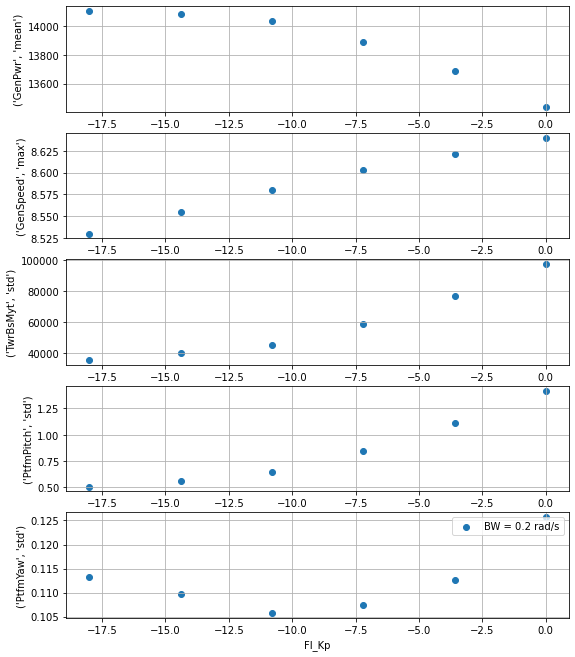

In [324]:
# Do plotting over these channels

ss_channels = [
               ('GenPwr','mean'),
#                ('GenPwr','max'),
               ('GenSpeed','max'),
#                ('RotThrust','max'),
               ('TwrBsMyt','std'),
               ('PtfmPitch','std'),
               ('PtfmYaw','std'),
#                ('NcIMUTAxs','std') 
              ]

# lin_del = FileTools.load_yaml('/Users/dzalkind/Tools/WEIS-3/outputs/iea15mw/PC_sweep_play/LinResults.yaml')

param_ind = 3


plt.rcParams["figure.figsize"] = [9,2.25 * len(ss_channels)]
# plt.rc('font', size=14)          # controls default text sizes

fig, ax = plt.subplots(len(ss_channels),1)

for st_i in st:
    for ichan, chan in enumerate(ss_channels):
        ax[ichan].scatter(st_i[parameters[param_ind]].loc[indSel],st_i[chan[0],chan[1]].loc[indSel])
        ax[ichan].set_xlabel(parameters[param_ind][1])
        ax[ichan].set_ylabel(chan)
        ax[ichan].grid(True)

#     legs = tuple([os.path.basename(test) for test in test_dir])
    
# fig.canvas.toolbar_visible = True
# fig.canvas.header_visible = False
# fig.canvas.resizable = True

plt.legend(('BW = 0.2 rad/s','BW = 0.1 rad/s'))
plt.show()

# Review Load Ranking

In [325]:
lr[0]['TwrBsMyt']

,max,max_case_idx,std,std_case_idx
0,466251.280013,0,97397.767626,0
1,452063.895653,1,76543.233997,1
2,448309.450438,2,58693.694958,2
3,442863.077844,3,45200.162526,3
4,437802.018188,4,39616.767372,4
5,433103.019075,5,35295.542878,5


 # Plot Selected Cases

Fl_Pitcom is not available as an output channel.
FA_AccR is not available as an output channel.
SS_dOmF is not available as an output channel.


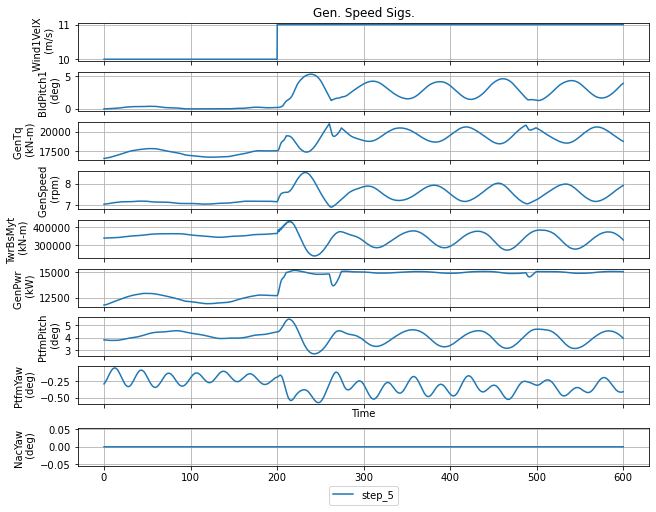

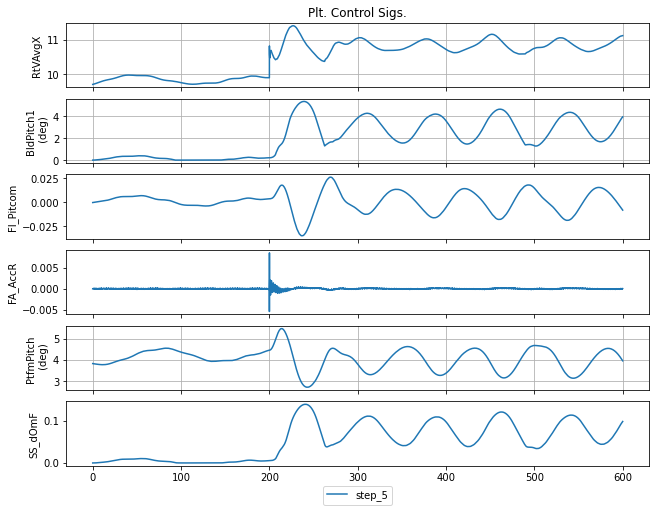

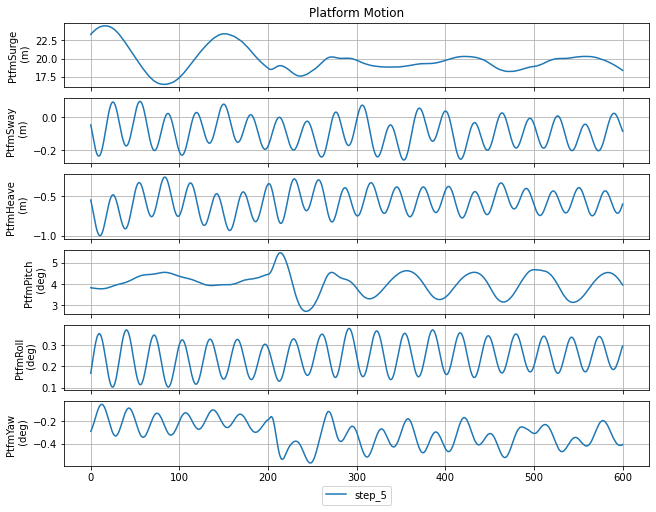

In [326]:
# Select Case I.D.s
case_ids = [5]


output_ext = '.out'
plt.rcParams["figure.figsize"] = [9,7]

#  Define Plot cases 
cases = {}
cases['Gen. Speed Sigs.'] = ['Wind1VelX', 'BldPitch1', 'GenTq', 'GenSpeed','TwrBsMyt','GenPwr','PtfmPitch','PtfmYaw','NacYaw']
cases['Plt. Control Sigs.'] = ['RtVAvgxh', 'BldPitch1', 'Fl_Pitcom', 'FA_AccR','PtfmPitch','SS_dOmF']
cases['Platform Motion'] = ['PtfmSurge', 'PtfmSway', 'PtfmHeave', 'PtfmPitch','PtfmRoll','PtfmYaw']


case_outs = [outs[case_id] for outs in outfiles for case_id in case_ids]

# Rosco outfiles
r_outfiles = [[os.path.join(test, cn + '.RO.dbg') for cn in cm[0].Case_Name] for test in test_dir]
r_case_outs = [r_outs[case_id] for r_outs in r_outfiles for case_id in case_ids]

# for i_case, case in enumerate(case_ids):
fast_out = fast_io.load_fast_out(case_outs, tmin=200)
rosco_out = fast_io.load_fast_out(r_case_outs, tmin=200)
    
# Combine outputs
comb_out = [None] * len(fast_out)
for i, (r_out, f_out) in enumerate(zip(rosco_out,fast_out)):
    r_out.update(f_out)
    comb_out[i] = r_out

# Plot
fig, ax = fast_pl.plot_fast_out(cases, comb_out, showplot=False)

# # hard code axes labels because 
# ax[1][0].set_ylabel('RtVAvgX')
# ax[1][2].set_ylabel('Fl_Pitcom')
# ax[1][3].set_ylabel('FA_AccR')
# ax[1][5].set_ylabel('SS_dOmF')  


# legs = tuple([os.path.basename(test) for test in test_dir])
# plt.legend(legs, loc='upper center', bbox_to_anchor=(
#                     0.5, 0.0), borderaxespad=2, ncol=2)

ax[0][7].set_xlabel('Time')
# l1 = fig[0].legend(('BW = 0.1 rad/s','BW = 0.2 rad/s'))

plt.show()



In [38]:
# cont_out = '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_fixed_ps100_const_pwr/simp/step_0'


outfiles
case_outs
# # c
# # rosco_out = fast_io.load_fast_out(cont_out[i_case], tmin=200)
# # case_outs

# rosco_out = fast_io.load_fast_out(r_case_outs[i_case], tmin=200)
# # case_outs
# # fastout[0]

# # test_dir
# # comb_out = [comb_out.append(r_out.update(f_out)) for (r_out, f_out) in zip(rosco_out,fast_out)]

# # zip(rosco_out,fast_out)

# comb_out = [None] * len(test_dir)
# for i, (r_out, f_out) in enumerate(zip(rosco_out,fast_out)):
#     r_out.update(f_out)
#     comb_out[i] = r_out
    
    
    
# for i_case, case in enumerate(case_ids):
fast_out = fast_io.load_fast_out(case_outs, tmin=200)
rosco_out = fast_io.load_fast_out(r_case_outs, tmin=200)
    


In [39]:
# Combine outputs
comb_out = [None] * len(fast_out)
for i, (r_out, f_out) in enumerate(zip(rosco_out,fast_out)):
    r_out.update(f_out)
    comb_out[i] = r_out

comb_out

[{'Time': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 5.9998e+02, 5.9999e+02,
         6.0000e+02]),
  'FA_AccF': array([1.136e-05, 1.134e-05, 1.132e-05, ..., 2.112e-06, 1.371e-06,
         6.292e-07]),
  'FA_AccR': array([ 4.204e-05,  3.824e-05,  3.607e-05, ..., -3.368e-04, -3.371e-04,
         -3.333e-04]),
  'RotSpeed': array([6.353, 6.353, 6.353, ..., 6.869, 6.869, 6.868]),
  'RotSpeedF': array([0.6649, 0.6649, 0.6649, ..., 0.729 , 0.7289, 0.7288]),
  'GenSpeed': array([6.353, 6.353, 6.353, ..., 6.869, 6.869, 6.868]),
  'GenSpeedF': array([0.6649, 0.6649, 0.6649, ..., 0.729 , 0.7289, 0.7288]),
  'FA_Acc': array([-0.005625, -0.005682, -0.005675, ..., -0.09746 , -0.09746 ,
         -0.09748 ]),
  'Fl_Pitcom': array([-0.0003333, -0.0003311, -0.0003288, ...,  0.0401   ,  0.0401   ,
          0.0401   ]),
  'PC_MinPit': array([0.    , 0.    , 0.    , ..., 0.1098, 0.1098, 0.1098]),
  'SS_dOmF': array([-0.0002463, -0.0002463, -0.0002463, ...,  0.2234   ,  0.2235   ,
          0.2235  

0